Загружаем библиотеки

In [ ]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pathlib import Path
import requests
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
drive.mount('/content/drive')
print("Setup Complete")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup Complete


Датасет загружается напрямую из GitHub, что удобно для воспроизводимости эксперимента

In [ ]:
RAW_URL = "https://raw.githubusercontent.com/brick1ng5654/course-3/RafaelB/boml/lab_01/health_lifestyle_classification.csv"
DEST = Path("/content/data/health_lifestyle_classification.csv")
DEST.parent.mkdir(parents=True, exist_ok=True)

r = requests.get(RAW_URL, timeout=60)
r.raise_for_status()

DEST.write_bytes(r.content)
print(f"Saved to {DEST} ({DEST.stat().st_size/1_000_000:.2f} MB)")

Saved to /content/data/health_lifestyle_classification.csv (52.98 MB)


В датасете более 100+ тысяч строк и 41 признак. Выберем необходимое и отсеем лишнее.

Целевым признаком для предсказания будет target (Бинарная классификация): healthy (здоров) / diseased (болен). Важное уточнение, что данное понятие достаточно расплывчатое.

Из числовых признаков возьмём:

- age (Возраст)
- bmi (Индекс массы тела)
- blood pressure (Артериальное давление)
- calorie intake (Потребление калорий)
- cholesterol (Холестерин)
- daily steps (Ежедневное количество шагов)
- glucose (Глюкоза)
- heart rate (Пульс)
- insulin (Инсулин)
- sleep hours (Количество часов сна)
- stress level (Заявленный уровень стресса)
- sugar intake (Потреблнение сахара)
- water intake (Потребление воды)
- work hours (Количество часов работы)

Из категориальных признаков возьмём:

- alchohol consumption (Потребление алкоголя)
- caffeine intake (Потребление кофеина)
- diet type (Тип диенты: веганский, вегетаринский, всеядный, кето, палео)
- exercise type (Тип тренировок)
- gender (Пол)
- meals per day (Количество приёмов пищи в день)
- sleep quality (Качество сна)
- smoking level (Потребление сигарет)
- sunlight exposure (Ежедневное воздействие солнечного света)

Таким образом были убраны следующие признаки:

- bmi ?* (В виду взятия признака bmi, вслесдствие чего остальные показатели bmi не нужны)
- daily supplement dosage (В виду не до конца понятной классификации)
- device usage (В виду наименьшего влияния на результат заболевания)
- education level (В виду наименьшего влияния на результат заболевания)
- electrolyte level (В виду бесполезности признака, т.к. все строки одинаковые)
- enviromnent risk score (В виду бесполезности признака, т.к. все строки одинаковые)
- family history (В виду не до конца понятной бинарной классификации)
- gene marker flag (В виду бесполнезности признака, т.к. все строки одинаковые)
- healthcare access (В виду наименьшего влияния на результат заболевания)
- height (В виду ненужности признака из-за наличия признака bmi)
- income ((В виду наименьшего влияния на результат заболевания)
- insurance (В виду наименьшего влияния на результат заболевания)
- job type ((В виду наименьшего влияния на результат заболевания)
- mental health score (В виду схожести с заявленным уровнем стресса)
- mental health support (В виду наименьшего влияния на результат заболевания)
- occupation (В виду наименьшего влияния на результат заболевания)
- pet owner (В виду наименьшего влияния на результат заболевания)
- physical activity (В виду не до конца понятного получения значения признака)
- screen time (В виду наименьшего влияния на результат заболевания)
- waist size (В виду наименьшего влияния на результат заболевания)
- weight (В виду ненужности признака из-за наличия признака bmi)

#Подгружаем Датасет с директории.

In [ ]:
# Path of the file to read
filepath = "/content/data/health_lifestyle_classification.csv"
# Read the file into a variable DF
DF = pd.read_csv(filepath)

В переменной Filepath хранится путь к нашему Датасету. В переменно DF хранится Датафрейм.

#Делаем массив с признаками, которые будут удалены.

In [ ]:
delete_columns = [
    'screen_time',
    'family_history',
    'mental_health_score',
    'occupation',
    'mental_health_support',
    'device_usage',
    'healthcare_access',
    'insurance',
    'pet_owner',
    'height',
    'weight',
    'waist_size',
    'bmi',
    'physical_activity',
    'education_level',
    'job_type',
    'income',
    'electrolyte_level',
    'gene_marker_flag',
    'environmental_risk_score',
    'daily_supplement_dosage'
]

# Копируем основной датафрейм, чтобы он не подвергался изменениям
DF_cp = DF.copy()

# Удаление выбранных колон по массиву
for column in delete_columns:
    DF_cp = DF_cp.drop(column, axis=1)

# Заполним медианой строки с пустыми численными признаками
for column in DF_cp.columns:
  if DF_cp[column].dtype in ["int64","float64"]:
    medidan = DF_cp[column].median()
    DF_cp[column] = DF_cp[column].fillna(medidan)
  else:
    DF_cp.dropna(subset=[column],inplace=True)

#Нормализация данных
Используем one-hot encoding для нормализации качественных данных, а Min_Max для нормализации числовых данных.

In [ ]:
# Выбираем признаки типа object
categorical_col = DF_cp.select_dtypes(include=["object"]).columns

# Разбиваем их на подпризнаки
for column in categorical_col:
        one_hot = pd.get_dummies(DF_cp[column], prefix=column)
        DF_cp = DF_cp.drop(column, axis=1)
        DF_cp = pd.concat([DF_cp, one_hot], axis=1)

for column in DF_cp.columns:
  if column not in categorical_col:
    min_max_scaler = MinMaxScaler()
    DF_cp[column] = min_max_scaler.fit_transform(DF_cp[[column]])


#Удаляем дубликаты.

In [ ]:
DF_end = DF_cp.drop_duplicates()

#Проверяем типы данных
Убедимся, что все признаки имеют числовой тип.

In [ ]:
print(DF_end.dtypes)

survey_code                         float64
age                                 float64
bmi_estimated                       float64
bmi_scaled                          float64
bmi_corrected                       float64
blood_pressure                      float64
heart_rate                          float64
cholesterol                         float64
glucose                             float64
insulin                             float64
sleep_hours                         float64
work_hours                          float64
daily_steps                         float64
calorie_intake                      float64
sugar_intake                        float64
water_intake                        float64
stress_level                        float64
meals_per_day                       float64
gender_Female                       float64
gender_Male                         float64
sleep_quality_Excellent             float64
sleep_quality_Fair                  float64
sleep_quality_Good              

#Построение диаграммы рассеяния

Text(0, 0.5, 'Холестерин (нормализованный)')

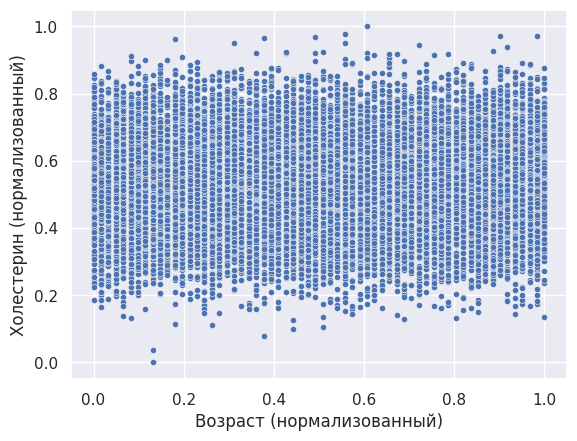

In [ ]:
sns.set(font_scale=1)
sns.scatterplot(
    x = 'age' ,
    y = 'cholesterol',
    data = DF_end,
    s=20
)
plt.xlabel("Возраст (нормализованный)")
plt.ylabel("Холестерин (нормализованный)")

#Построение Гистограмм Возраста и Холестерина.

Text(0, 0.5, 'Частота')

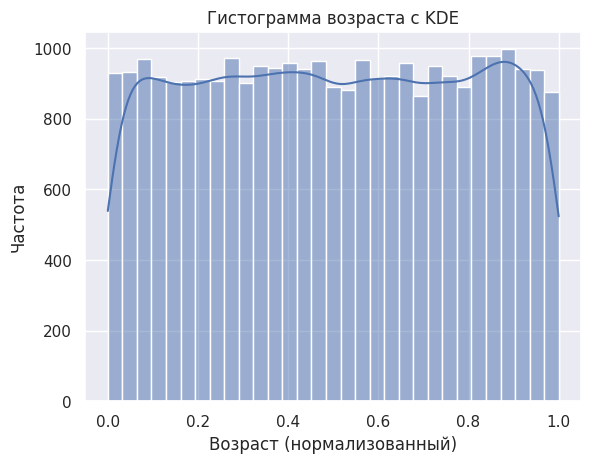

In [ ]:
sns.histplot(
    data=DF_end,
    x='age',
    kde = 'True')
plt.title('Гистограмма возраста с KDE')
plt.xlabel('Возраст (нормализованный)')
plt.ylabel('Частота')

Text(0, 0.5, 'Частота')

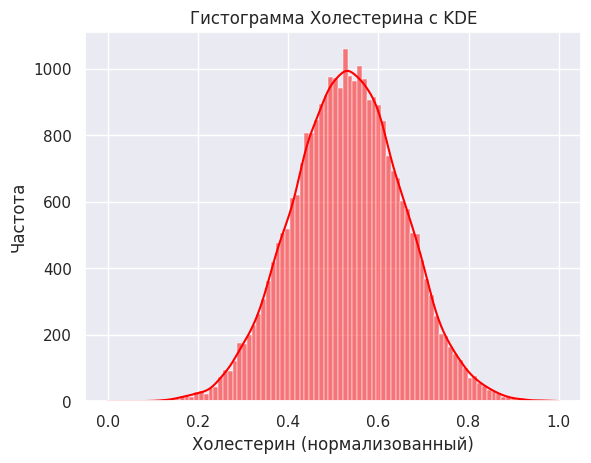

In [ ]:
sns.histplot(
    data=DF_end,
    x='cholesterol',
    kde = 'True',
    color = 'red')
plt.title('Гистограмма Холестерина с KDE')
plt.xlabel('Холестерин (нормализованный)')
plt.ylabel('Частота')

#Построение ящиков с усами для холестерина.

Text(0.5, 1.0, 'Холестерин по частоте употребление кофеина High')

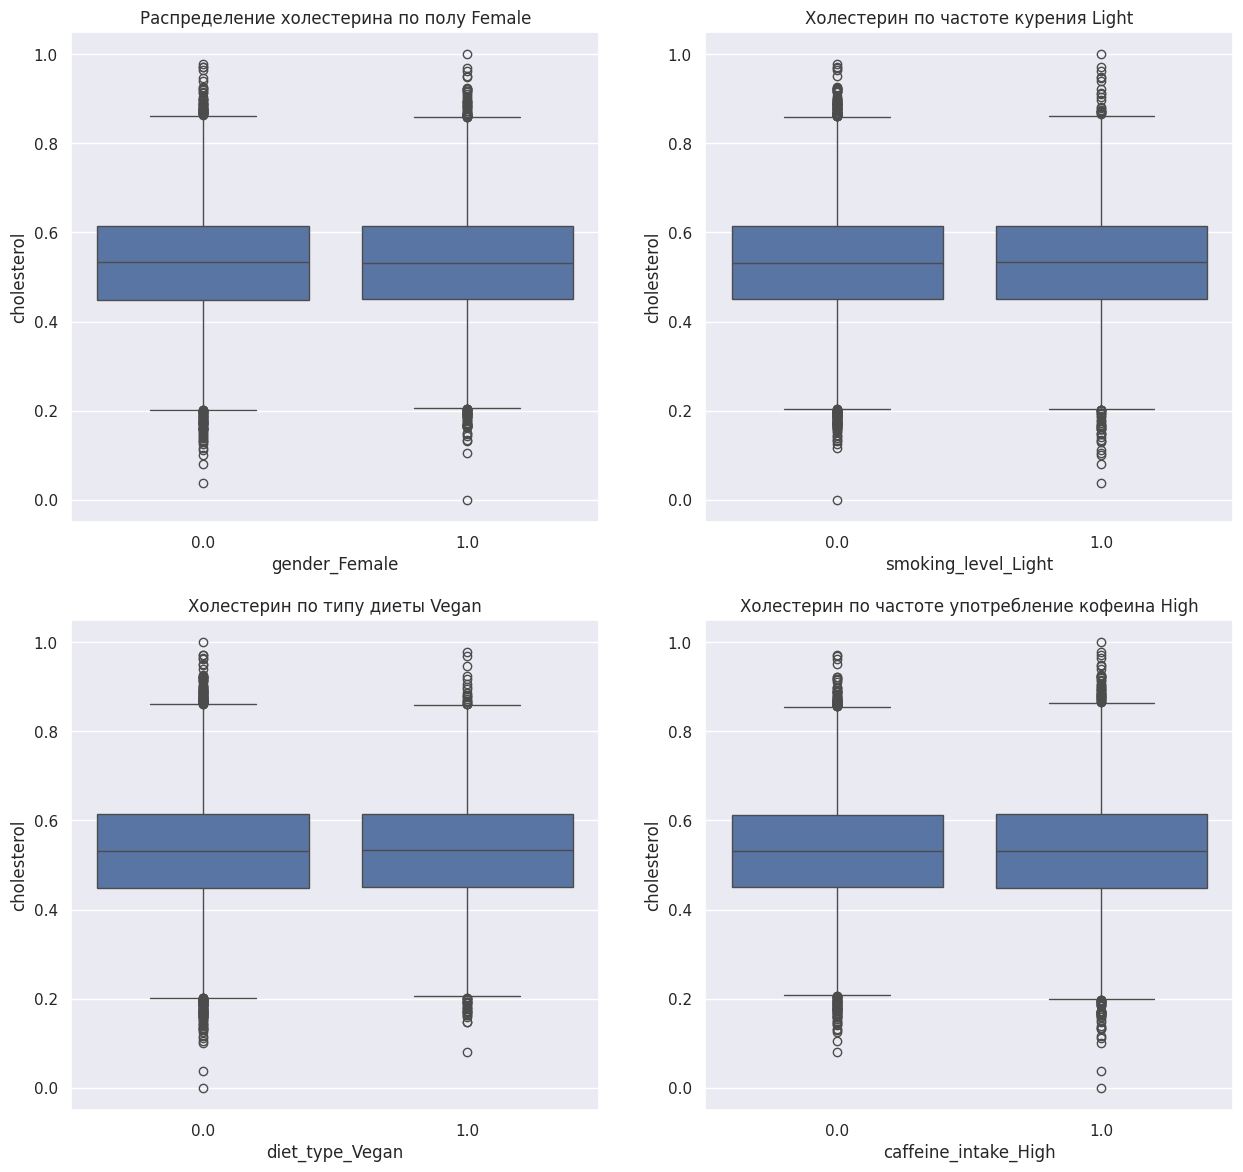

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 14))
sns.boxplot(
    data=DF_end,
    x='gender_Female',
    y='cholesterol',
    ax=axes[0,0])
axes[0,0].set_title('Распределение холестерина по полу Female')


sns.boxplot(data=DF_end,
            x='smoking_level_Light',
            y='cholesterol',
            ax=axes[0,1])
axes[0,1].set_title('Холестерин по частоте курения Light')

sns.boxplot(data=DF_end,
            x='diet_type_Vegan',
            y='cholesterol',
            ax=axes[1,0])
axes[1,0].set_title('Холестерин по типу диеты Vegan')


sns.boxplot(data=DF_end,
            x='caffeine_intake_High',
            y='cholesterol',
            ax=axes[1,1])
axes[1,1].set_title('Холестерин по частоте употребление кофеина High')


#Кореляция данных, нахождение выбросов и их удаление.

In [ ]:
corr_DF = DF_end.corr(method='spearman')
# Функция для нахождения выбросов
def outliers_indices(feature):
    '''
    Будем считать выбросами все точки, выходящие за пределы трёх сигм.
    '''
    mid = DF_end[feature].mean()
    sigma = DF_end[feature].std()
    return DF_end[(DF_end[feature] < mid - 3*sigma) | (DF_end[feature] > mid + 3*sigma)].index

wrong_specificity = []
specificity = DF_end.select_dtypes(include = ['number']).copy()

for specif in specificity:
  num_specificity = outliers_indices(specif)
  wrong_specificity.extend(num_specificity)

out = set(wrong_specificity)
print(f"Найдено выбросов: {len(out)}" )
DF_clean = DF_end.drop(out)
print(f"Количество строк после удаления выбросов: {len(DF_clean)}")

Найдено выбросов: 991
Количество строк после удаления выбросов: 27855


#Построение числовой матрицы с коэффицентами корреляции

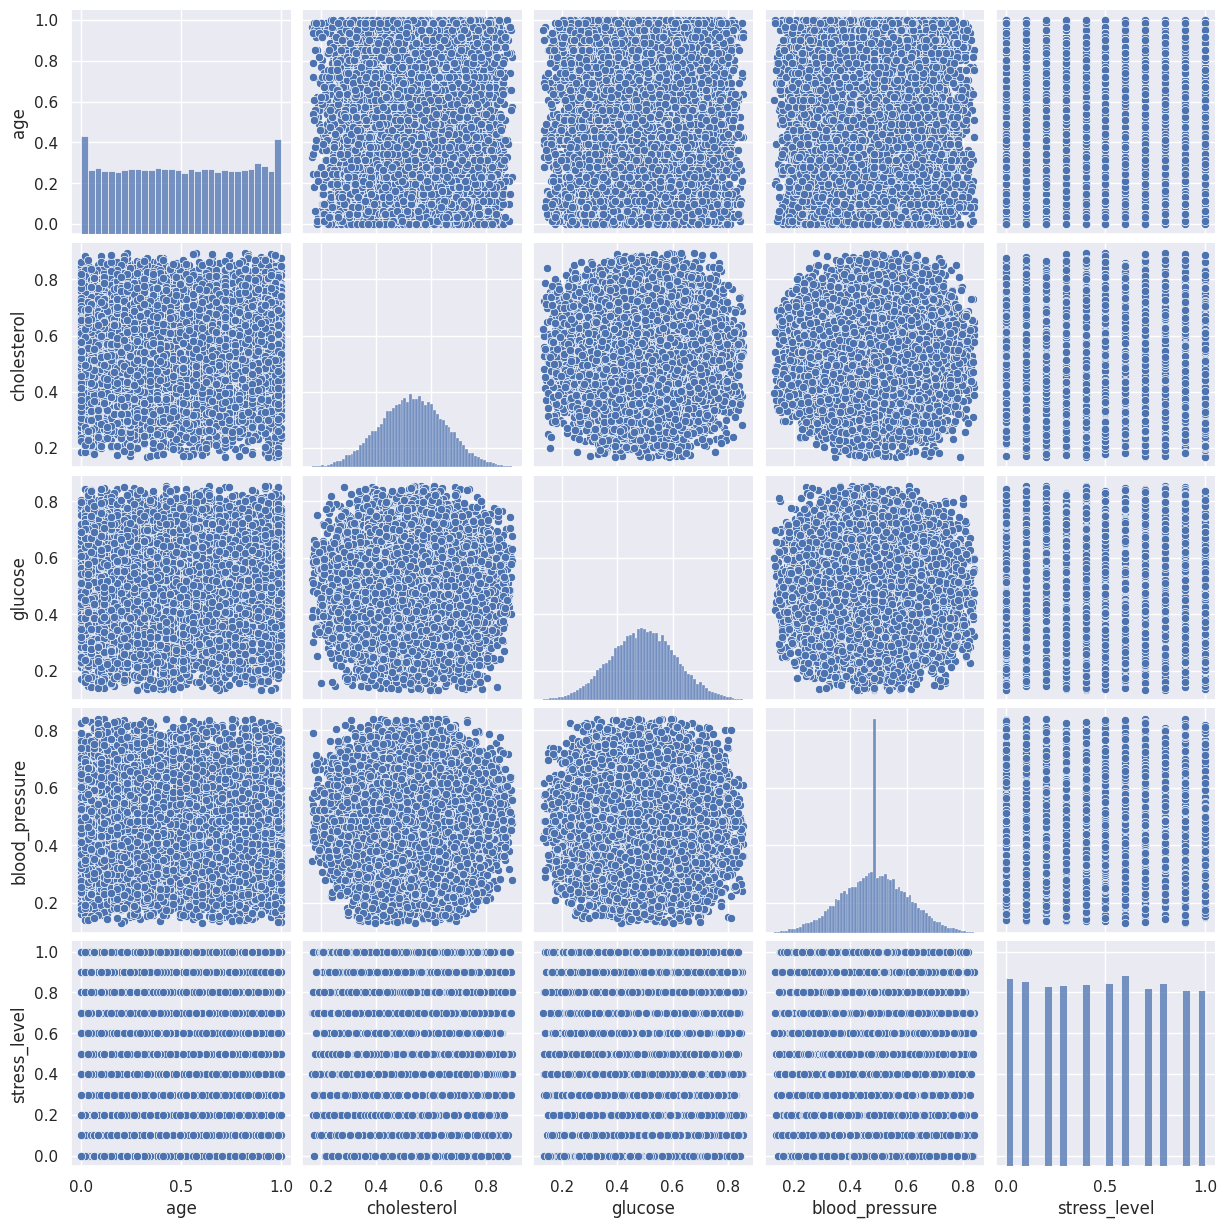

In [ ]:
Key = ['age', 'cholesterol', 'glucose', 'blood_pressure', 'stress_level']

sns.pairplot(DF_clean[Key]);

#Построение тепловой карты.

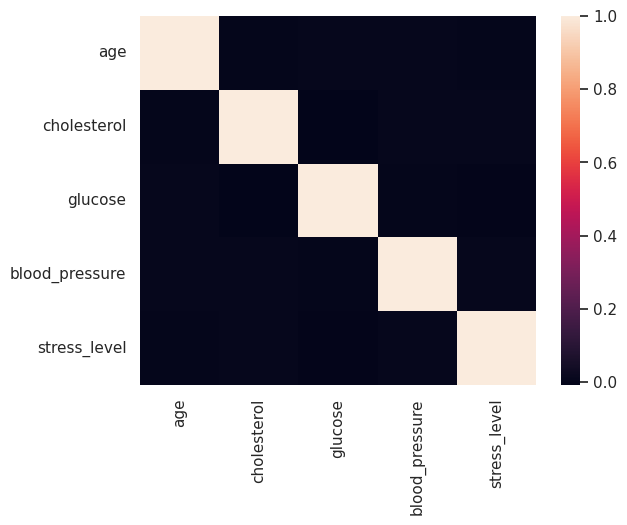

In [ ]:
sns.heatmap(DF_clean[Key].corr(method='spearman'));